In [1]:
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
from scipy import sparse
import anndata

/cristealab/xiwang/miniconda3/envs/llm_sc_benchmark/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [ ]:
##########################################################
# 1) CONFIG / PATHS
##########################################################
## Data directly downloaded from scTab: https://pklab.med.harvard.edu/felix/data/merlin_cxg_2023_05_15_sf-log1p.tar.gz
DATA_PATH = "/cristealab/xiwang/data/scTab_data/merlin_cxg_2023_05_15_sf-log1p"
VAL_DIR = os.path.join(DATA_PATH, "val")
LOOKUP_DIR = os.path.join(DATA_PATH, "categorical_lookup")
VAR_FILE = os.path.join(DATA_PATH, "var.parquet")  # 'feature_id', 'feature_name'

# Integer-coded metadata columns in df_val
CATEGORICAL_COLS = [
    "dataset_id",
    "donor_id",
    "assay",
    "cell_type",
    "development_stage",
    "disease",
    "tissue",
    "tissue_general",
    "tech_sample",
]

In [ ]:

## Saving the unique cell types

import os
import pandas as pd

## Data directly downloaded from scTab: https://pklab.med.harvard.edu/felix/data/merlin_cxg_2023_05_15_sf-log1p.tar.gz
DATA_PATH = "/cristealab/xiwang/data/scTab_data/merlin_cxg_2023_05_15_sf-log1p"

cell_type_file = os.path.join(DATA_PATH, "categorical_lookup", "cell_type.parquet")

# Load cell_type.parquet
df_cell_type = pd.read_parquet(cell_type_file)

# If the integer codes are stored in the index and string labels in the "label" column:
df_cell_type.reset_index(inplace=True)  # columns => ["index", "label"]
unique_cell_types = df_cell_type["label"].unique()

# Write to a TXT file, one cell type per line
output_path = "scTab_unique_cell_types.txt"
with open(output_path, "w") as f:
    for ctype in unique_cell_types:
        f.write(f"{ctype}\n")

print(f"Saved {len(unique_cell_types)} unique cell types to {output_path}")

Saved 164 unique cell types to /cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_1k/scTab_unique_cell_types.txt


In [3]:
##########################################################
# 2) LOAD VALIDATION SET
##########################################################
df_val = dd.read_parquet(VAL_DIR).compute()
print("df_val shape (rows x cols):", df_val.shape)
print("df_val columns:", df_val.columns.tolist())

df_val shape (rows x cols): (3500032, 13)
df_val columns: ['X', 'soma_joinid', 'is_primary_data', 'dataset_id', 'donor_id', 'assay', 'cell_type', 'development_stage', 'disease', 'tissue', 'tissue_general', 'tech_sample', 'idx']


In [15]:
df_val['X'][0].shape

(19331,)

In [4]:
##########################################################
# 3) MAP INTEGER-CODED METADATA TO STRING LABELS
#
# For each column in CATEGORICAL_COLS:
#   - rename <col> => <col>_index in df_val
#   - load <col>.parquet (which has integer index & a "label" column)
#   - reset the lookup index, rename "index" => <col>_index, "label" => <col>
#   - merge on <col>_index
#
##########################################################
for col in CATEGORICAL_COLS:
    if col not in df_val.columns:
        print(f"WARNING: '{col}' not in df_val. Skipping.")
        continue

    # (A) Rename the integer-coded column to <col>_index
    df_val.rename(columns={col: f"{col}_index"}, inplace=True)

    # (B) Load the lookup file <col>.parquet
    lookup_file = os.path.join(LOOKUP_DIR, f"{col}.parquet")
    if not os.path.exists(lookup_file):
        print(f"WARNING: no lookup file for {col} => {lookup_file}")
        continue

    df_lookup = pd.read_parquet(lookup_file)
    print(f"Loaded {col} lookup shape:", df_lookup.shape)
    print(df_lookup.head(3))

    # (C) Convert the lookup index into a column & rename
    df_lookup.reset_index(inplace=True)  # now columns => ["index", "label"]
    df_lookup.rename(
        columns={
            "index": f"{col}_index",  # same name as in df_val
            "label": col              # store the string label in the original col name
        },
        inplace=True
    )

    # (D) Merge
    df_val = df_val.merge(df_lookup, on=f"{col}_index", how="left")

print("\nAfter merging, df_val shape:", df_val.shape)
print("df_val columns:", df_val.columns.tolist())


Loaded dataset_id lookup shape: (249, 1)
                                  label
0  00476f9f-ebc1-4b72-b541-32f912ce36ea
1  01209dce-3575-4bed-b1df-129f57fbc031
2  0129dbd9-a7d3-4f6b-96b9-1da155a93748
Loaded donor_id lookup shape: (4314, 1)
       label
0          1
1         10
2  1000_1001
Loaded assay lookup shape: (7, 1)
                            label
0  10x 3' transcription profiling
1                       10x 3' v1
2                       10x 3' v2
Loaded cell_type lookup shape: (164, 1)
                              label
0                            B cell
1               Bergmann glial cell
2  CD14-low, CD16-positive monocyte
Loaded development_stage lookup shape: (161, 1)
                      label
0   1-month-old human stage
1    1-year-old human stage
2  10-month-old human stage
Loaded disease lookup shape: (52, 1)
                         label
0            Alzheimer disease
1  B-cell non-Hodgkin lymphoma
2            Barrett esophagus
Loaded tissue lookup shape: (197

In [8]:
##########################################################
# 4) SUBSAMPLE: 10k, then 1k
##########################################################
df_10k = df_val.sample(n=10_000, random_state=42)
print("df_10k shape:", df_10k.shape)

df_1k = df_10k.sample(n=1_000, random_state=999)
print("df_1k shape:", df_1k.shape)

df_10k shape: (10000, 22)
df_1k shape: (1000, 22)


In [28]:
##########################################################
# 5) BUILD ANNDATA WITH var.parquet
#
# We assume var.parquet has 2 columns: ["feature_id", "feature_name"]
# and an index of "0","1","2", ... as strings. We'll convert
# that index to int, so it matches each column in X.
##########################################################

def to_anndata(df, filename, var_file=VAR_FILE):
    """
    Convert a DataFrame (with 'X' column) into an AnnData object.
    - var_file: path to var.parquet, containing:
        index => '0','1','2',...
        columns => ['feature_id', 'feature_name']
    - We convert the var index to int, so it's [0..(n_genes-1)]
    - .var keeps feature_id, feature_name as columns
    """
    # (A) Build expression matrix
    X_list = df["X"].values  # shape => n_cells
    X_array = np.stack(X_list, axis=0)  # => (n_cells, n_genes)

    # (B) obs => all columns except 'X'
    obs_df = df.drop(columns=["X"]).copy()

    # (C) Load var.parquet
    if os.path.exists(var_file):
        df_var = pd.read_parquet(var_file)
        print(f"df_var shape => {df_var.shape}, columns => {df_var.columns.tolist()}")
        # e.g. (19331, 2) with columns ["feature_id", "feature_name"]

        # Convert index from string to int
        df_var.index = df_var.index.astype(int)
        df_var.sort_index(inplace=True)  # ensure ascending 0..19330

        # Quick dimension check
        n_genes_file = df_var.shape[0]
        n_genes_x = X_array.shape[1]
        if n_genes_file != n_genes_x:
            print(f"WARNING: mismatch gene count => var={n_genes_file} vs X={n_genes_x}")

        var_df = df_var
    else:
        print(f"No var file found => {var_file}. Using empty var.")
        var_df = None

    # (D) Create AnnData
    if var_df is not None:
        adata = anndata.AnnData(
            X=sparse.csr_matrix(X_array),
            obs=obs_df,
            var=var_df
        )
    else:
        adata = anndata.AnnData(
            X=sparse.csr_matrix(X_array),
            obs=obs_df
        )

    # (E) Save
    adata.write_h5ad(filename)
    print(f"Wrote {filename} | shape={adata.shape} | var.shape={adata.var.shape}")

In [29]:
##########################################################
# 6) CONVERT 10k and 1k => ANNDATA
##########################################################
to_anndata(df_10k, "/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_10k/scTab_validation_10k_cells.h5ad")
to_anndata(df_1k,  "/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_1k/scTab_validation_1k_cells.h5ad")

print("\nAll done! You now have 'validation_10k_cells.h5ad' and 'validation_1k_cells.h5ad' with:")
print("- integer-coded columns => <col>_index + string-labeled columns => <col>")
print("- .var.index => [0..(n_genes-1)] (feature_index), .var['feature_name'] => gene symbols.")

df_var shape => (19331, 2), columns => ['feature_id', 'feature_name']


/cristealab/xiwang/miniconda3/envs/llm_sc_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/cristealab/xiwang/miniconda3/envs/llm_sc_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Wrote /cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_10k/scTab_validation_10k_cells.h5ad | shape=(10000, 19331) | var.shape=(19331, 2)
df_var shape => (19331, 2), columns => ['feature_id', 'feature_name']


/cristealab/xiwang/miniconda3/envs/llm_sc_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/cristealab/xiwang/miniconda3/envs/llm_sc_benchmark/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Wrote /cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_1k/scTab_validation_1k_cells.h5ad | shape=(1000, 19331) | var.shape=(19331, 2)

All done! You now have 'validation_10k_cells.h5ad' and 'validation_1k_cells.h5ad' with:
- integer-coded columns => <col>_index + string-labeled columns => <col>
- .var.index => [0..(n_genes-1)] (feature_index), .var['feature_name'] => gene symbols.


In [30]:
import anndata

def verify_h5ad(filepath):
    """
    Loads an h5ad file and prints basic summaries to verify content.
    """
    adata = anndata.read_h5ad(filepath)
    
    # Print the overall AnnData shape (cells x genes)
    print(f"\n=== Verifying '{filepath}' ===")
    print(f"Shape: {adata.shape}")
    print("obs columns:", list(adata.obs.columns))
    
    # Optionally show first few rows of obs
    print("\n.obs (head):")
    print(adata.obs.head())
    
    # If your var is large, just show the columns
    print("\n.var columns:", list(adata.var.columns))
    print("First 5 rows of .var:")
    print(adata.var.head(5))
    
    # Example: Check if X is sparse or dense
    print("\nX format:", type(adata.X))
    print("=== Done ===")

# Example usage for your 10k and 1k subsets:
verify_h5ad("/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_10k/scTab_validation_10k_cells.h5ad")
verify_h5ad("/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_1k/scTab_validation_1k_cells.h5ad")


=== Verifying '/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_10k/scTab_validation_10k_cells.h5ad' ===
Shape: (10000, 19331)
obs columns: ['soma_joinid', 'is_primary_data', 'dataset_id_index', 'donor_id_index', 'assay_index', 'cell_type_index', 'development_stage_index', 'disease_index', 'tissue_index', 'tissue_general_index', 'tech_sample_index', 'idx', 'dataset_id', 'donor_id', 'assay', 'cell_type', 'development_stage', 'disease', 'tissue', 'tissue_general', 'tech_sample']

.obs (head):
         soma_joinid  is_primary_data  dataset_id_index  donor_id_index  \
954744      23647736             True               121            1311   
244829      37095195             True               220            3526   
1521379     19003836             True                43            1914   
3430810     12826196             True               169            3838   
294664      11688854             True                57            1556   

         assay_index  cell_type_index  d

In [31]:
import scanpy as sc
adata = sc.read_h5ad("/cristealab/xiwang/Outputs/llm_sc_benchmark/scTab/subsampled_10k/scTab_validation_10k_cells.h5ad")
adata

AnnData object with n_obs × n_vars = 10000 × 19331
    obs: 'soma_joinid', 'is_primary_data', 'dataset_id_index', 'donor_id_index', 'assay_index', 'cell_type_index', 'development_stage_index', 'disease_index', 'tissue_index', 'tissue_general_index', 'tech_sample_index', 'idx', 'dataset_id', 'donor_id', 'assay', 'cell_type', 'development_stage', 'disease', 'tissue', 'tissue_general', 'tech_sample'
    var: 'feature_id', 'feature_name'

In [32]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 20930303 stored elements and shape (10000, 19331)>

In [34]:
adata.var['feature_name']

0              OR4F5
1             OR4F29
2             OR4F16
3             SAMD11
4              NOC2L
            ...     
19326         UGT1A3
19327         UGT1A5
19328         WASH6P
19329     PDCD6-AHRR
19330    GET1-SH3BGR
Name: feature_name, Length: 19331, dtype: object

/tmp/ipykernel_1367607/4277930195.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

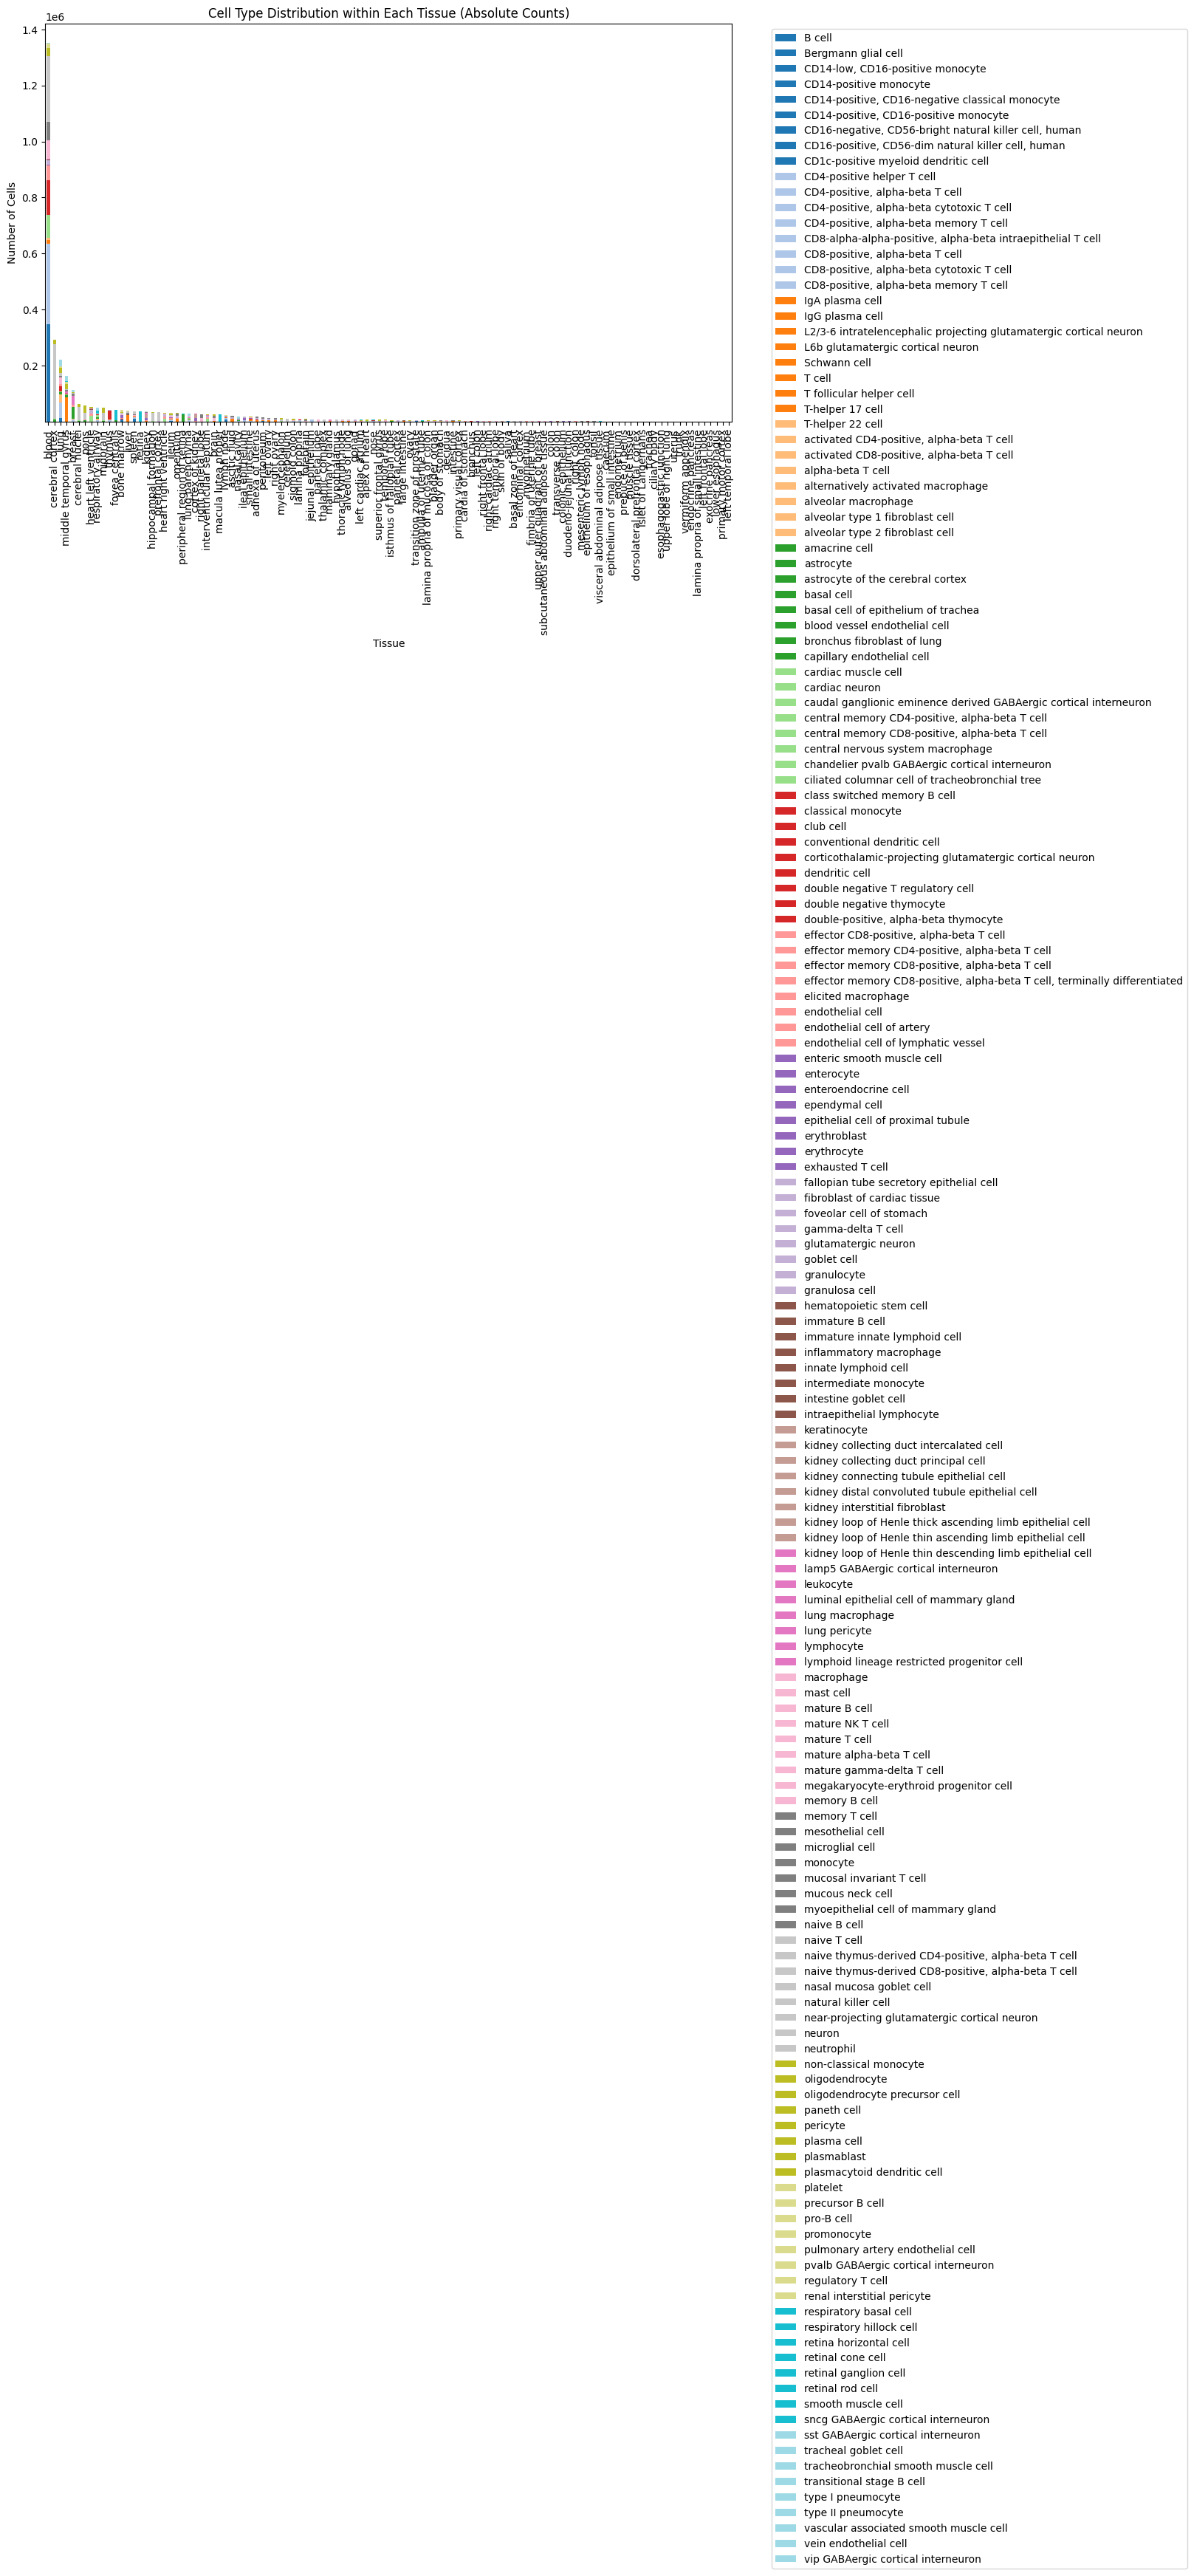

/tmp/ipykernel_1367607/4277930195.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

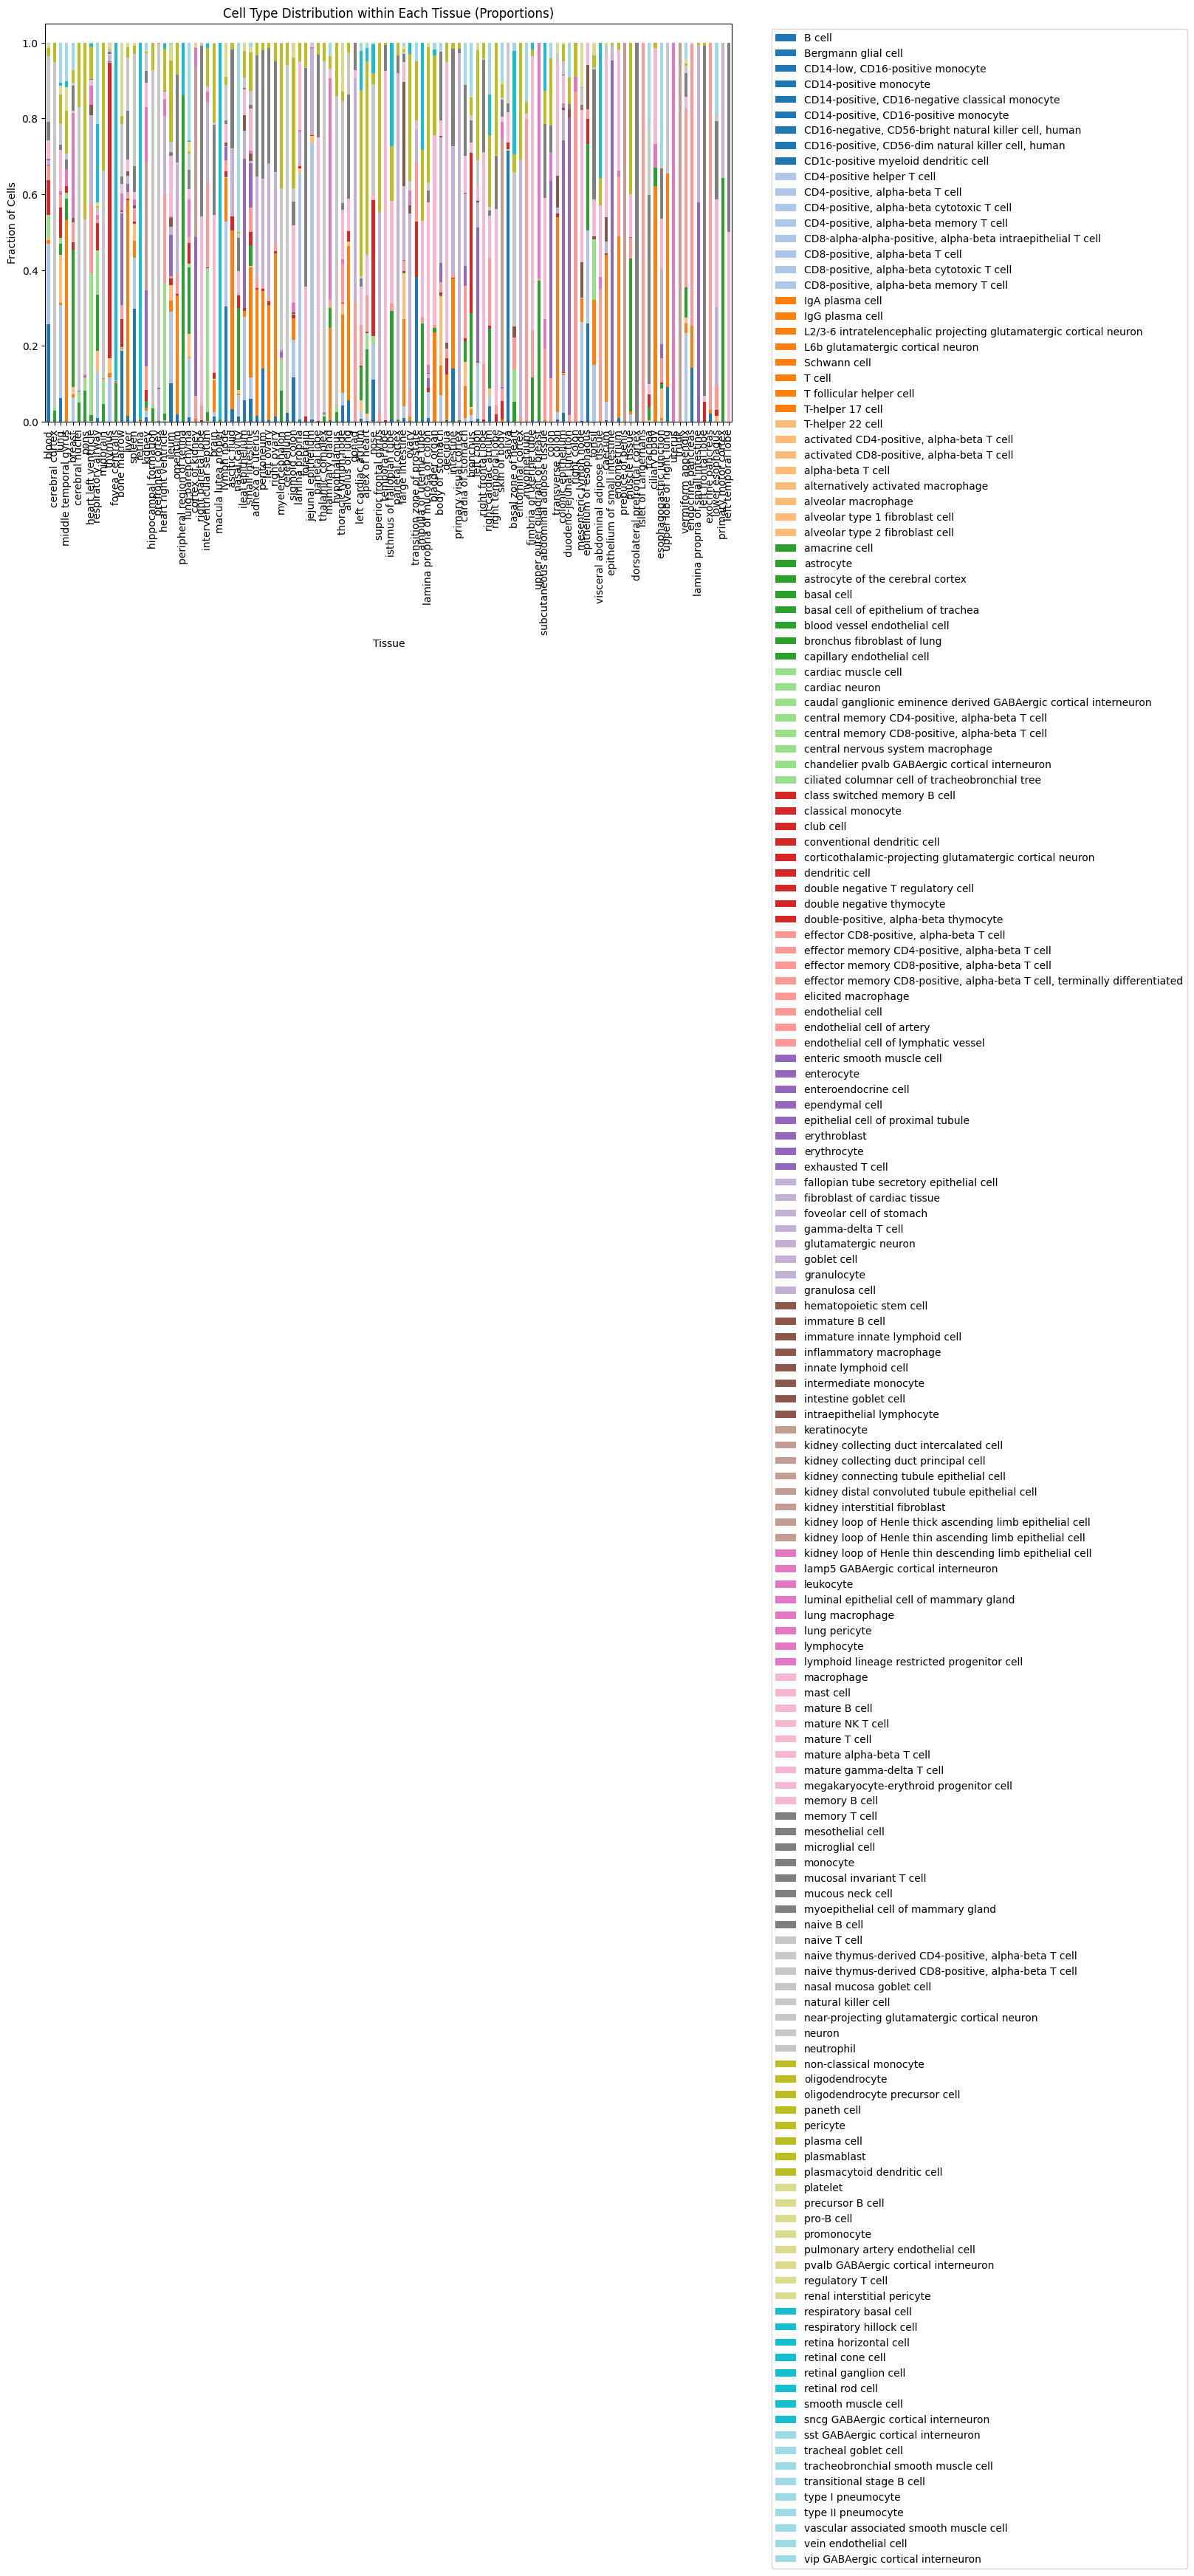

/tmp/ipykernel_1367607/4277930195.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

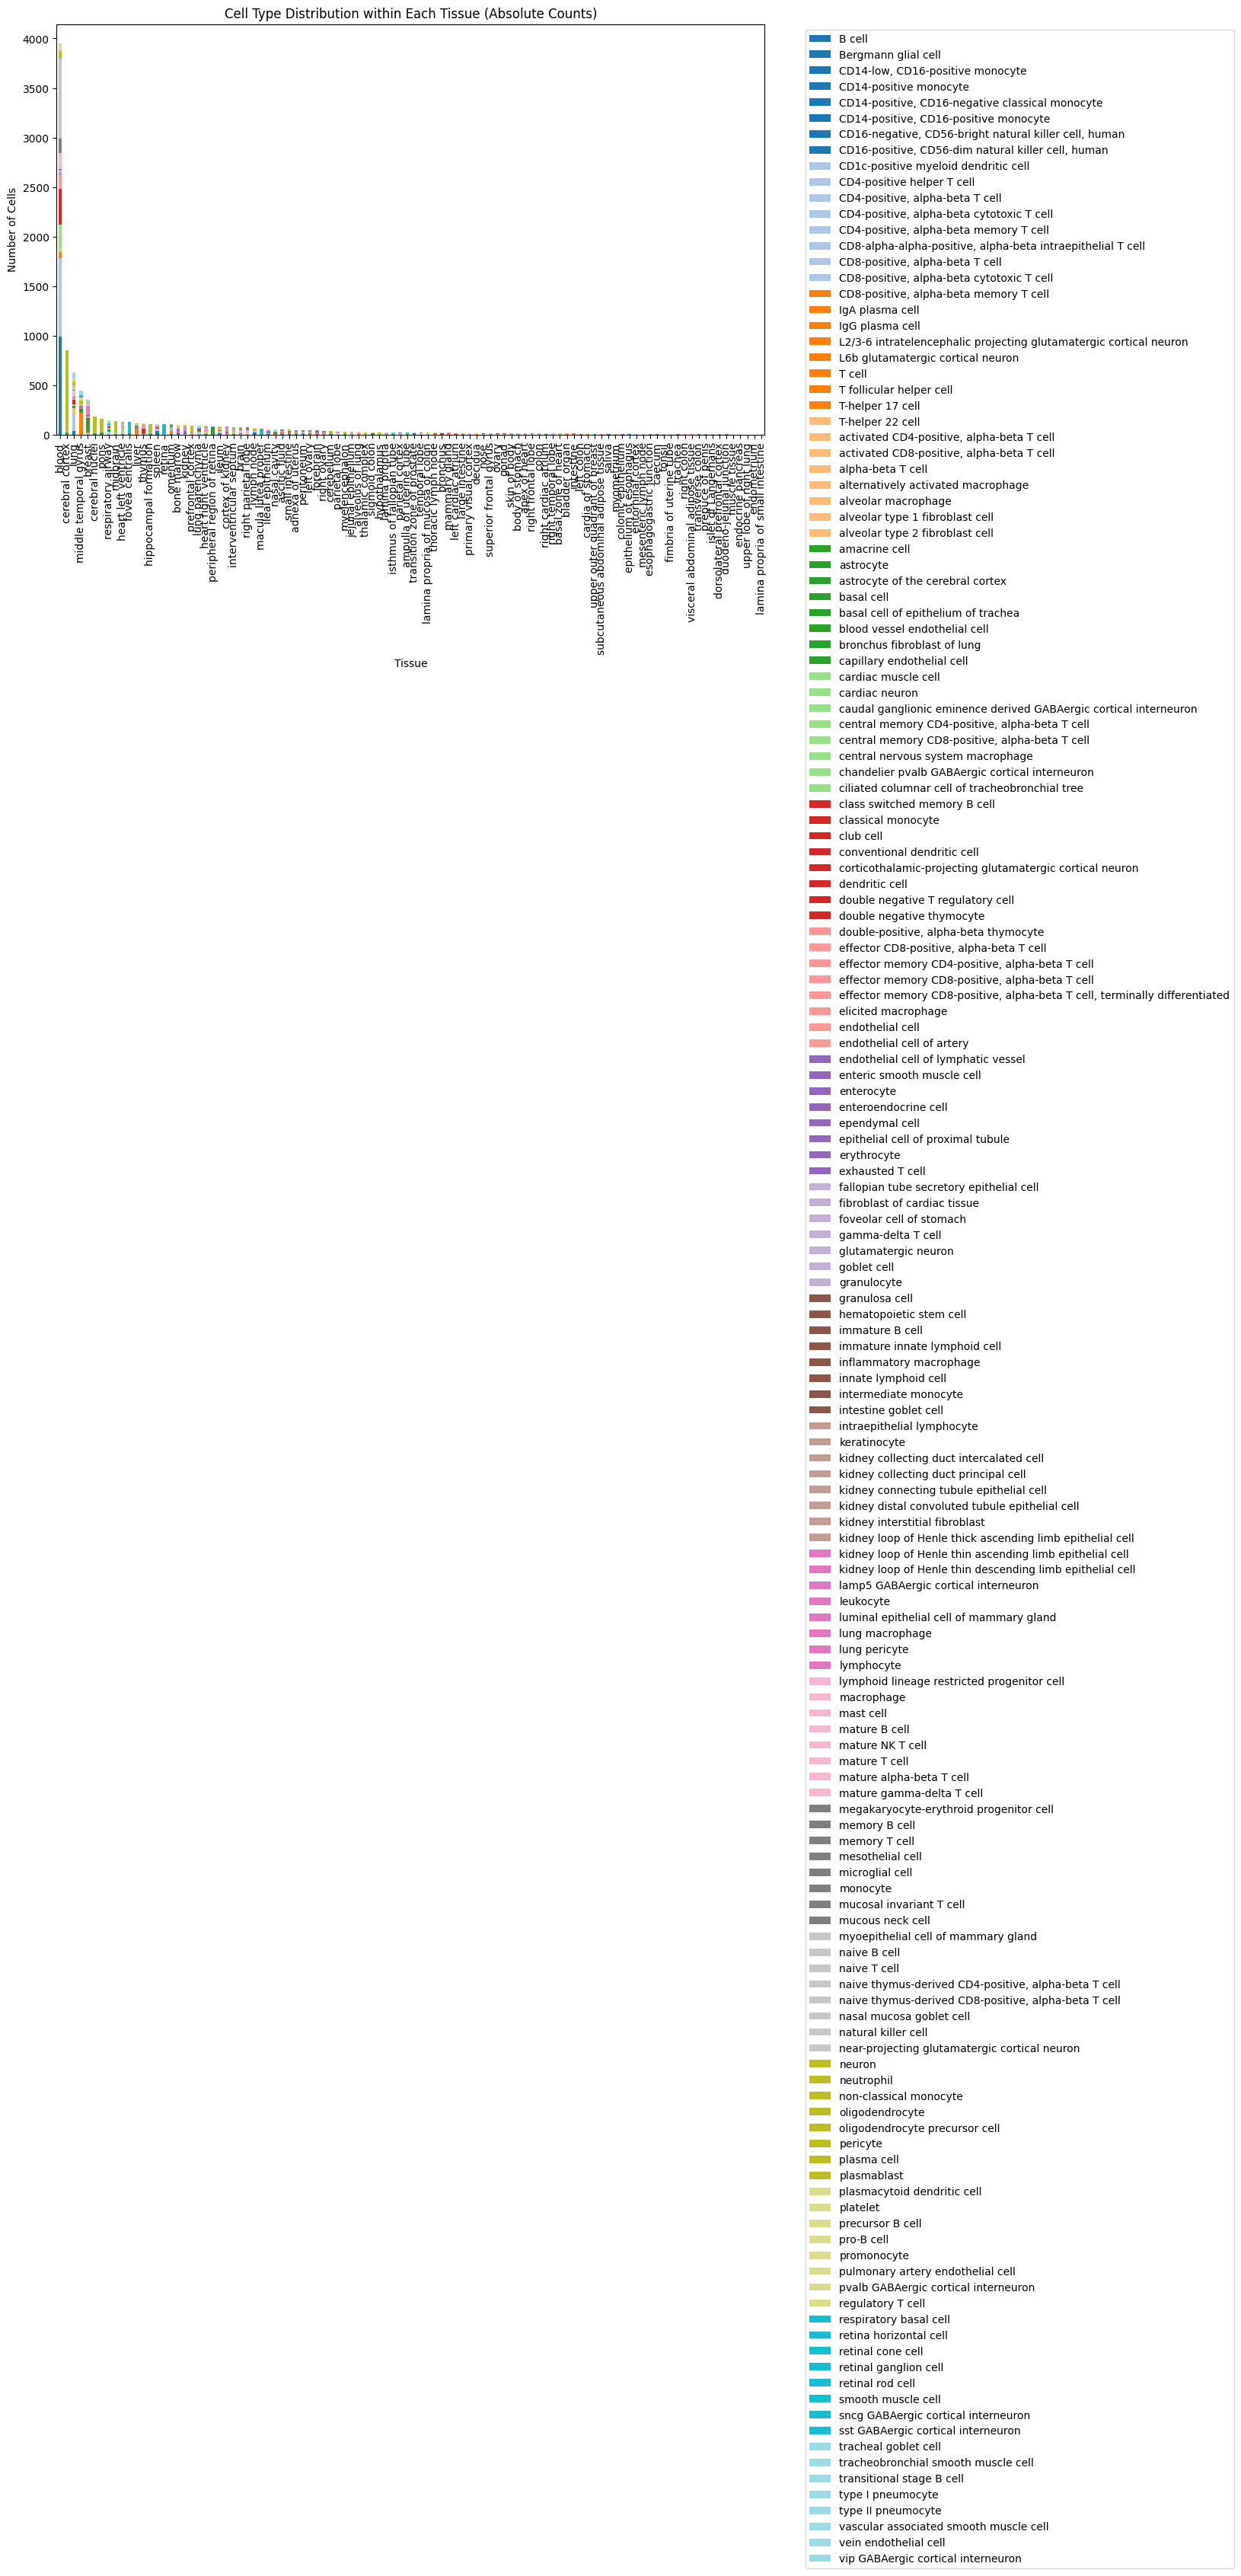

/tmp/ipykernel_1367607/4277930195.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

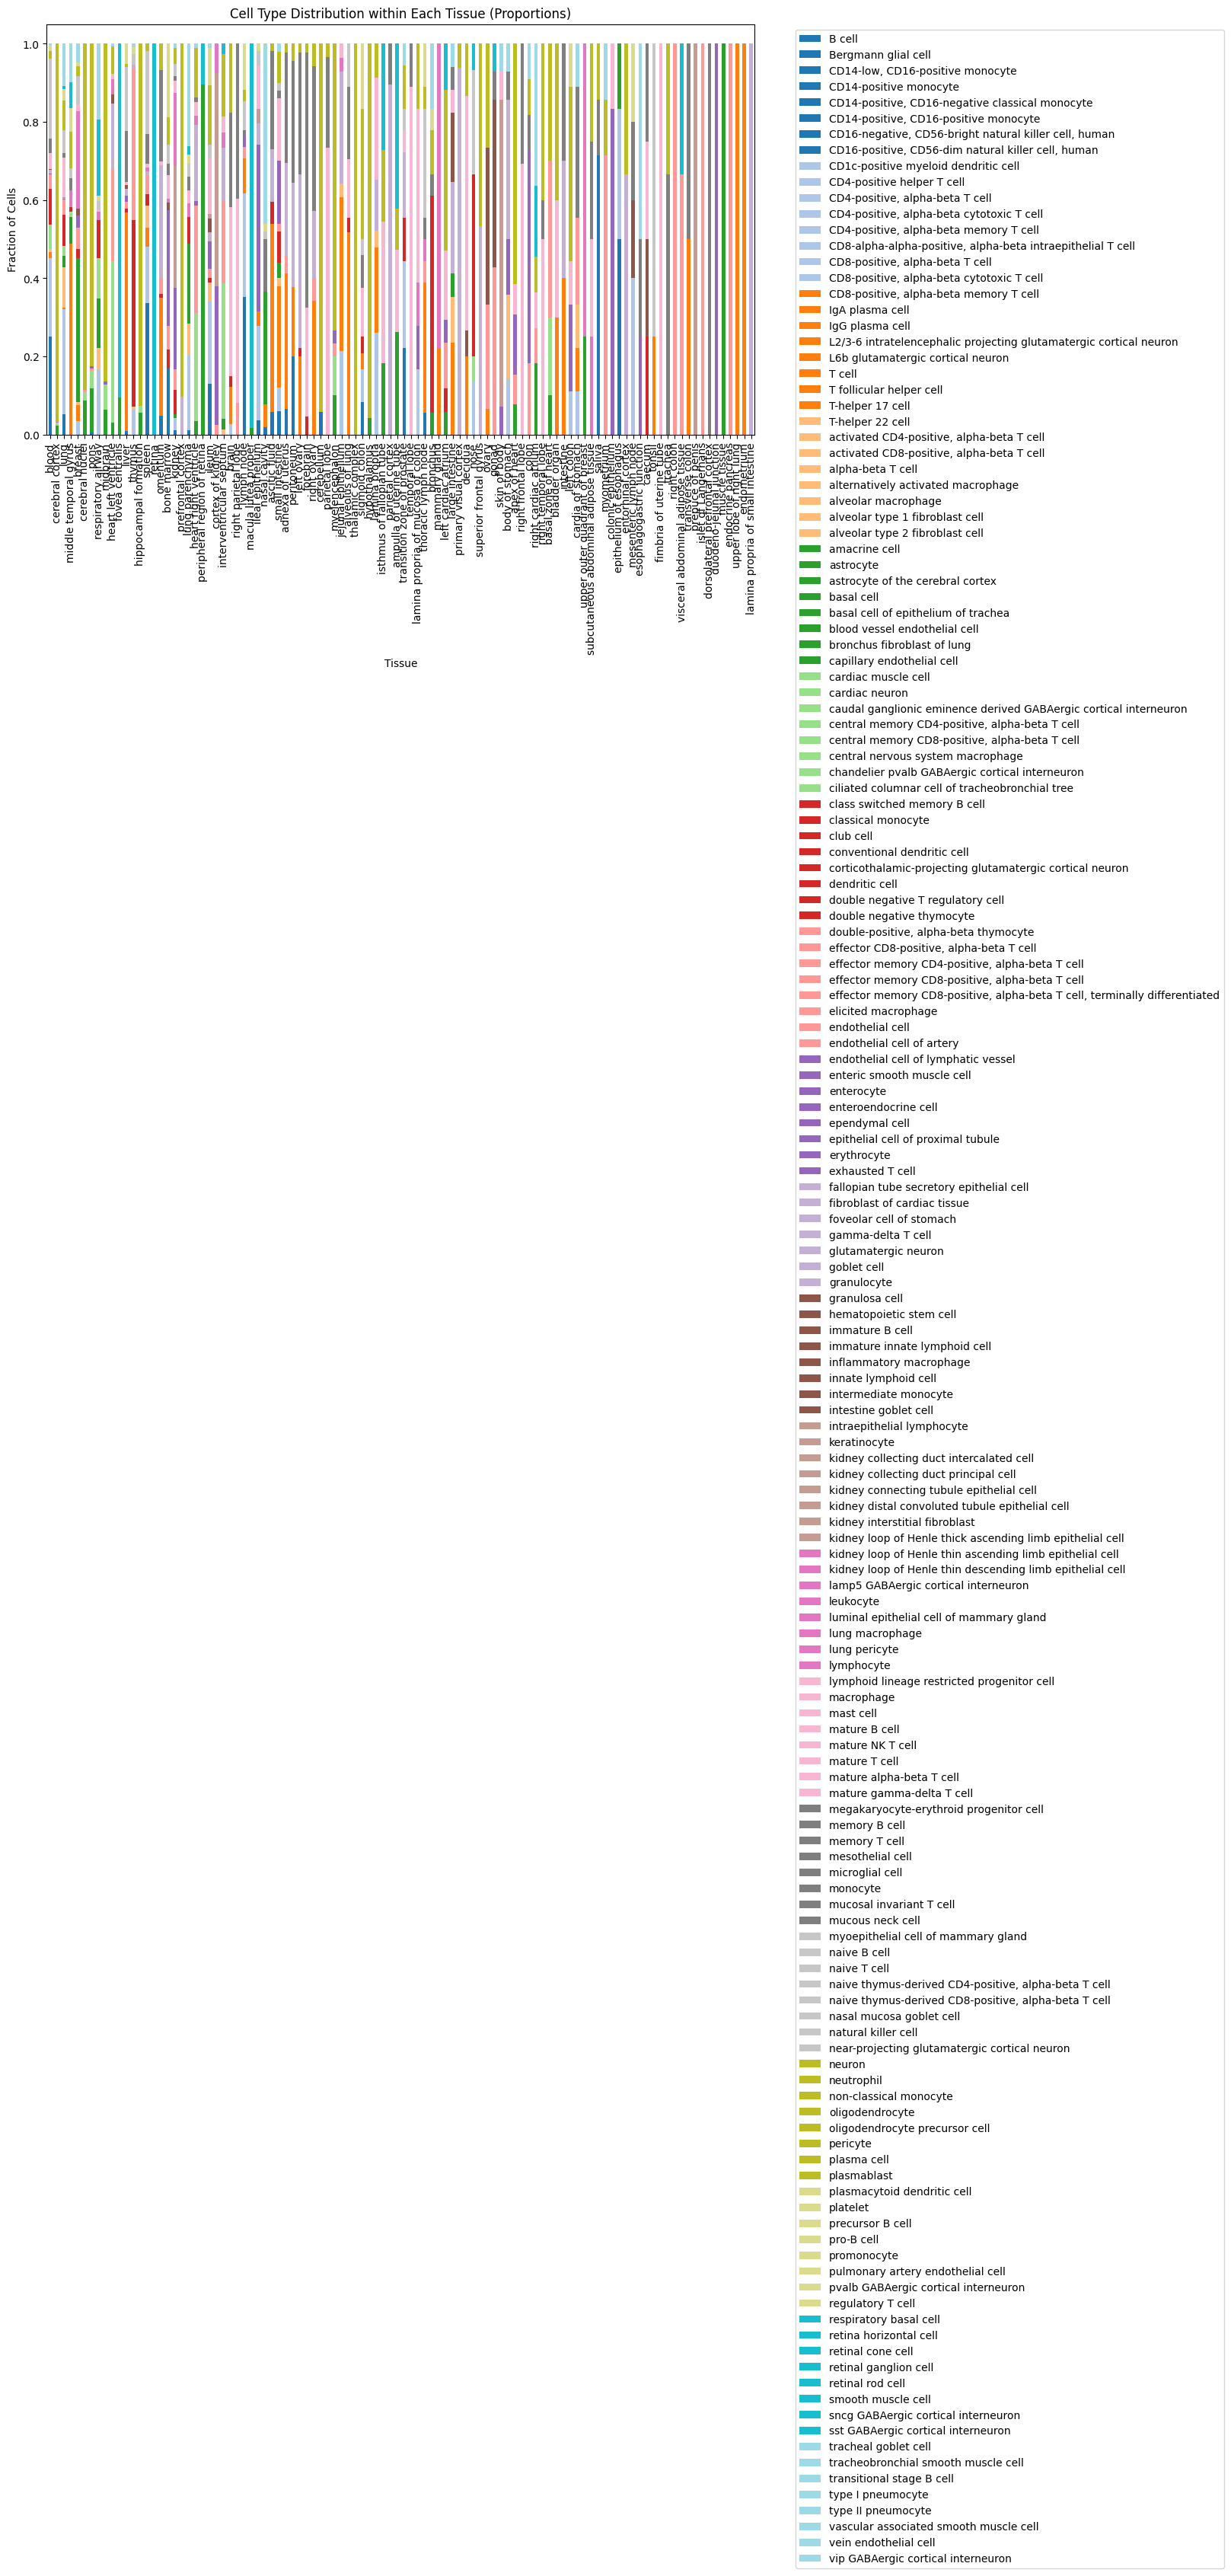

/tmp/ipykernel_1367607/4277930195.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

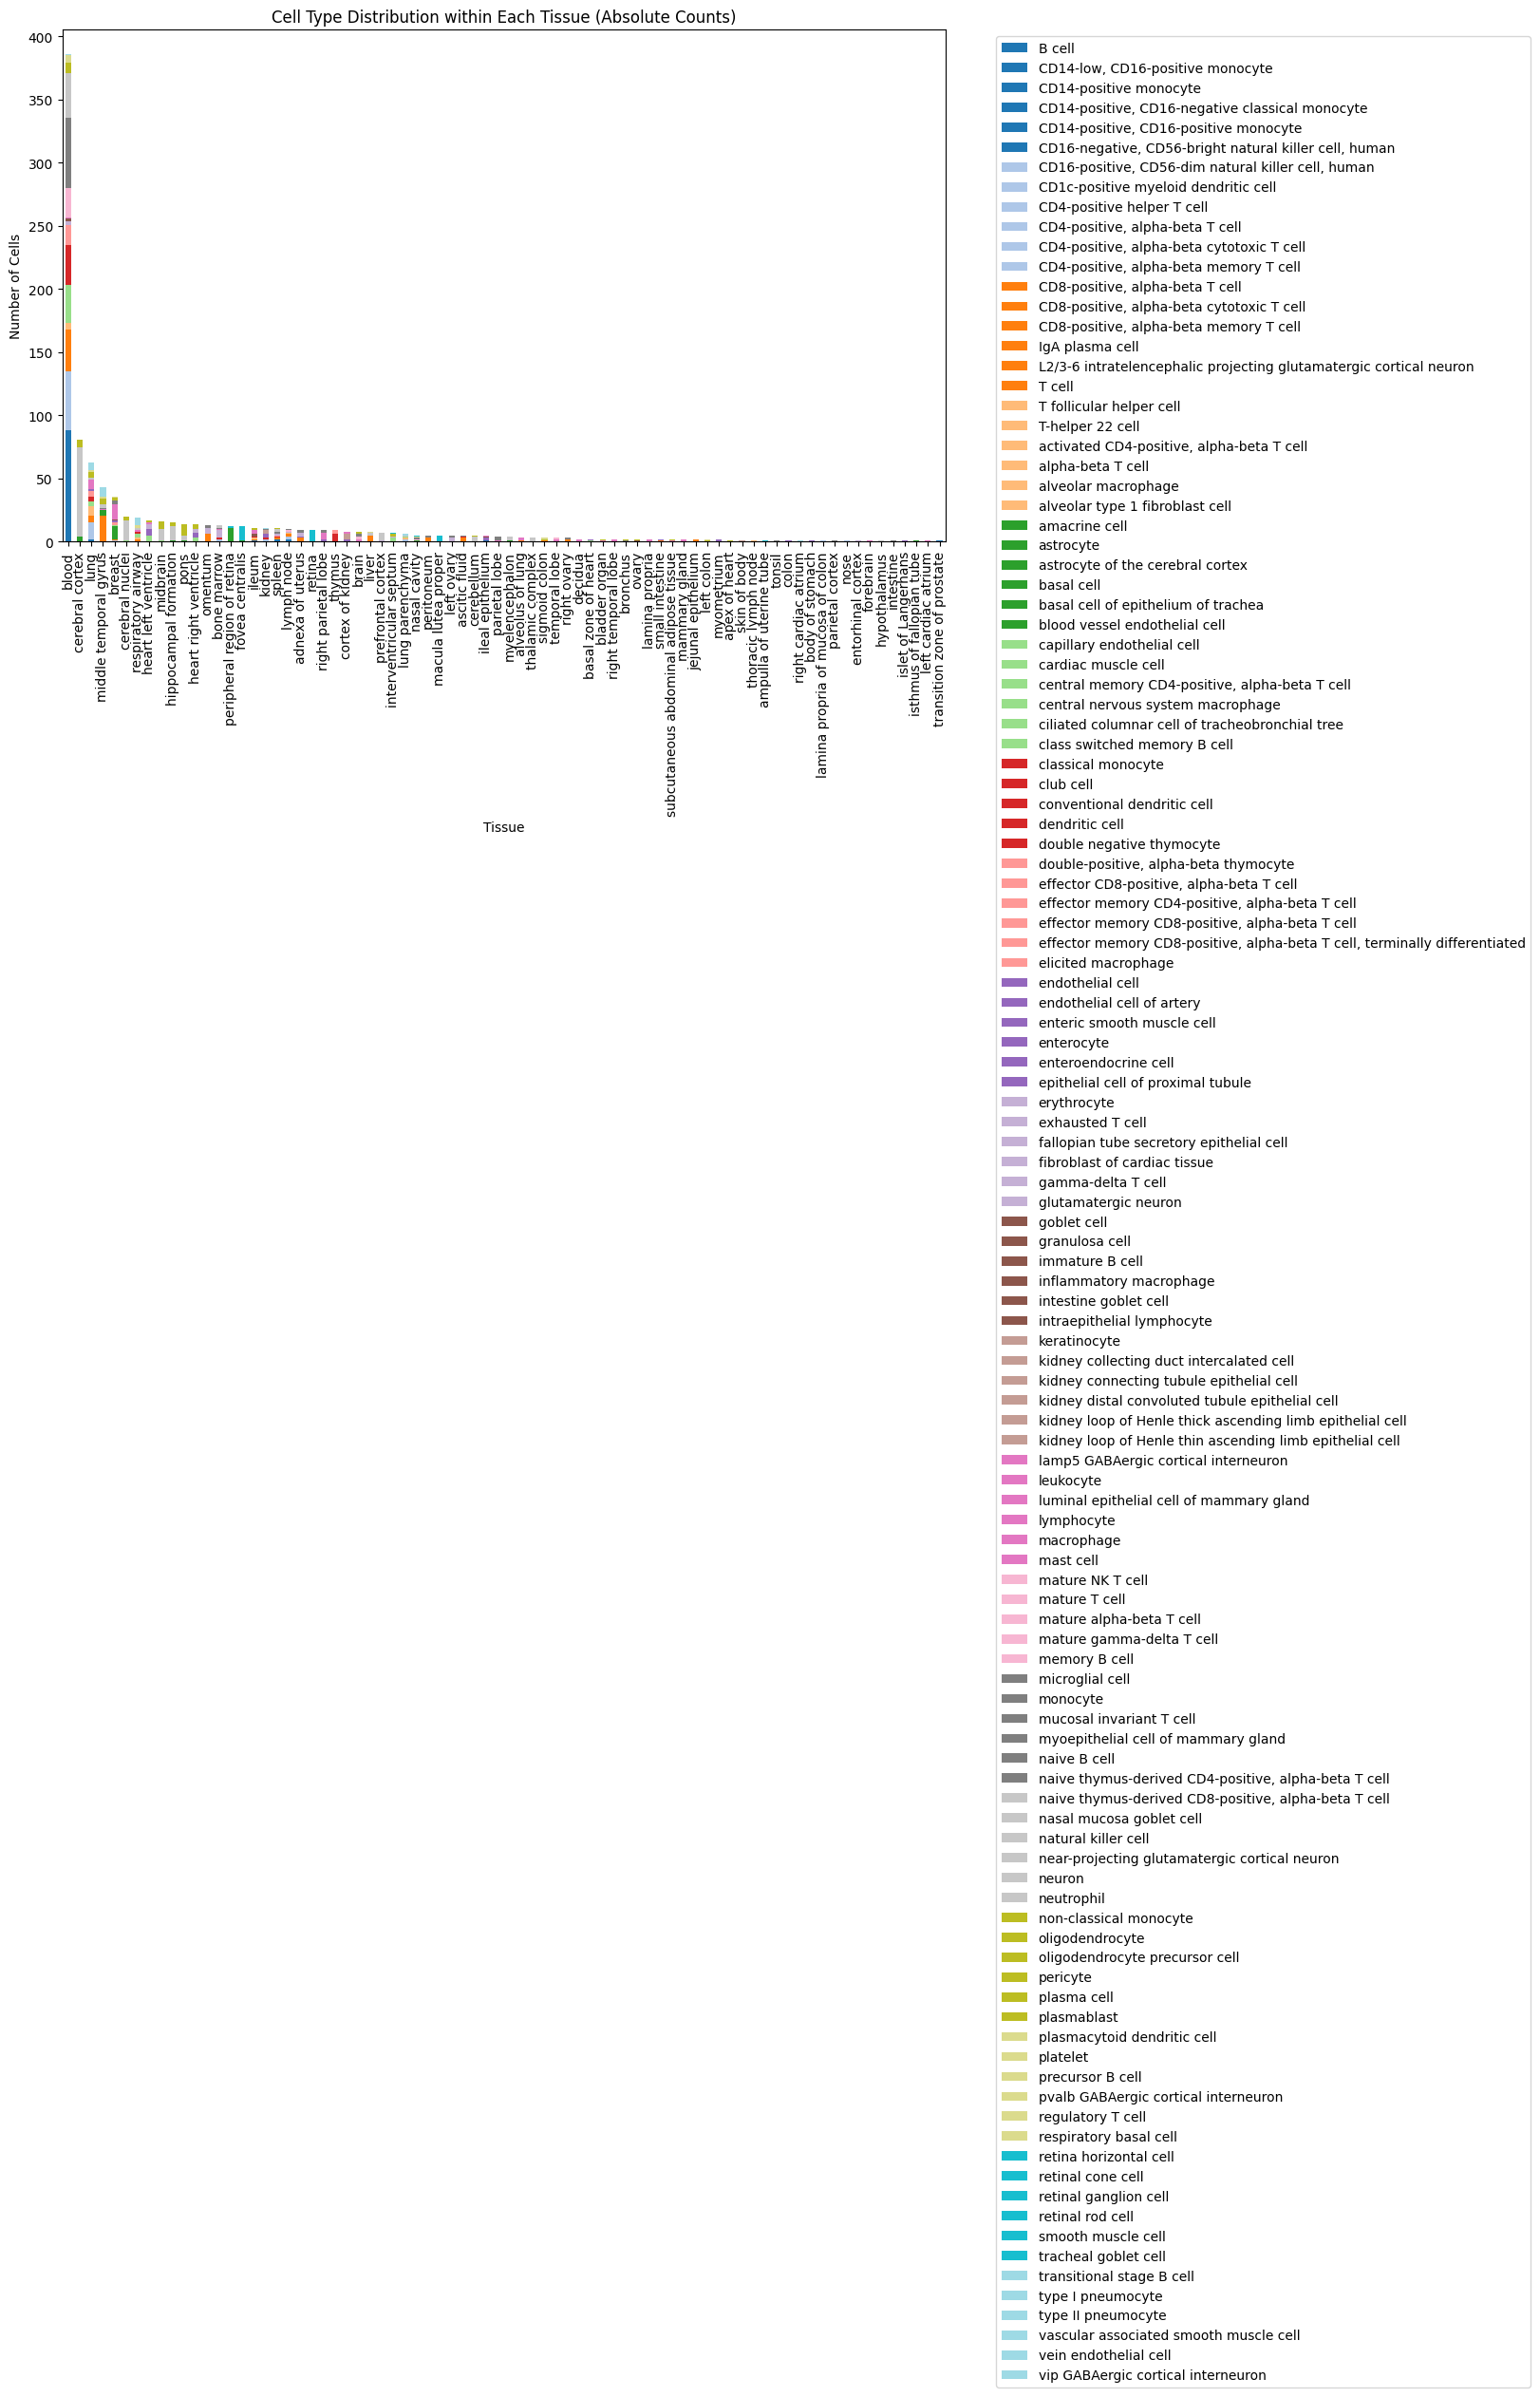

/tmp/ipykernel_1367607/4277930195.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x700 with 0 Axes>

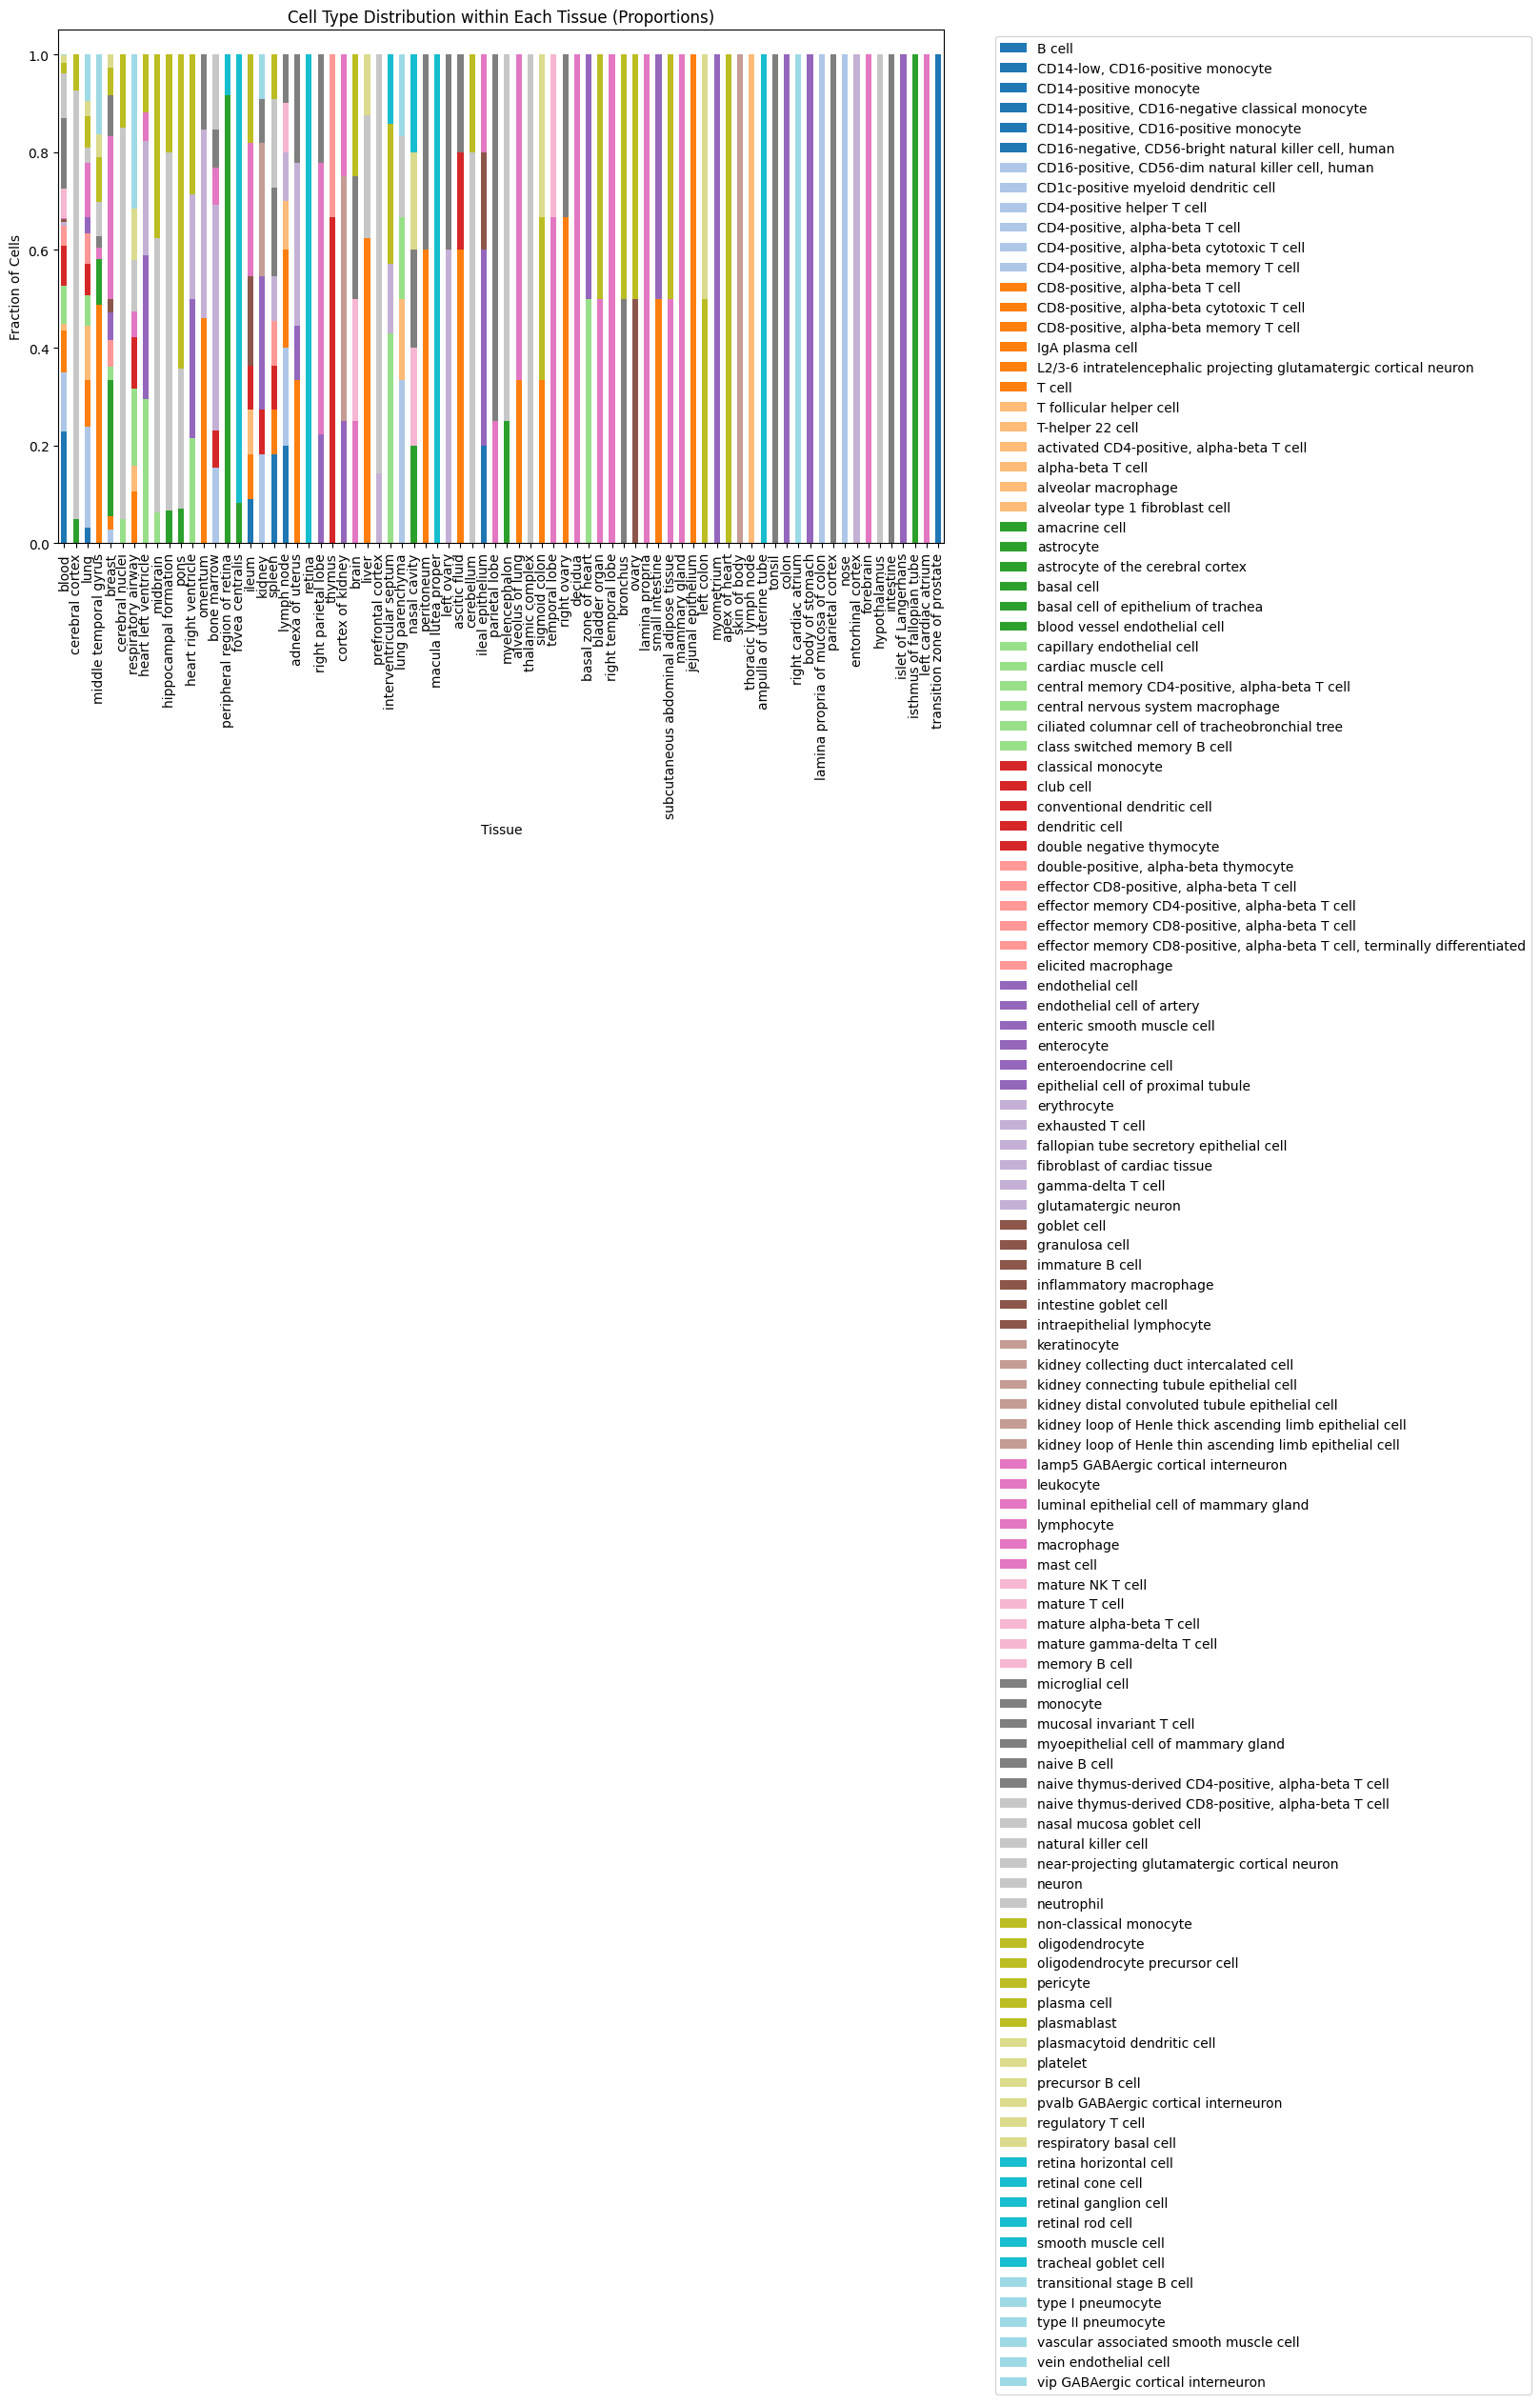

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_celltype_by_tissue_stacked(df, tissue_col="tissue", celltype_col="cell_type"):
    """
    Plots two stacked bar charts:
      1) Absolute counts of each cell_type per tissue
      2) Proportion of each cell_type per tissue
    The DataFrame df must have string-labeled columns named tissue_col and celltype_col.
    
    If there are many tissues or cell types, consider filtering the DataFrame
    or limiting to the top N categories before plotting.
    """
    # Create a crosstab of Tissue x CellType
    ctab = pd.crosstab(df[tissue_col], df[celltype_col])

    # Sort rows by total descending, so highest total tissue is on top (left)
    ctab = ctab.loc[ctab.sum(axis=1).sort_values(ascending=False).index]

    # 1) Stacked bar of absolute counts
    plt.figure(figsize=(12, 7))
    ctab.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="tab20")
    plt.title("Cell Type Distribution within Each Tissue (Absolute Counts)")
    plt.xlabel("Tissue")
    plt.ylabel("Number of Cells")
    # place legend outside the plot if it's too large
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 2) Stacked bar of proportions
    ctab_prop = ctab.div(ctab.sum(axis=1), axis=0)  # row-wise normalization
    plt.figure(figsize=(12, 7))
    ctab_prop.plot(kind="bar", stacked=True, figsize=(12, 7), colormap="tab20")
    plt.title("Cell Type Distribution within Each Tissue (Proportions)")
    plt.xlabel("Tissue")
    plt.ylabel("Fraction of Cells")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# EXAMPLE USAGE:
# ---------------------------------------------------
# Suppose you already have:
#   - df_val      (the full validation set),
#   - df_10k      (10k subset),
#   - df_1k       (1k subset),
# and each has a string "tissue" column and a string "cell_type" column (not the integer codes).

# For the full validation set:
plot_celltype_by_tissue_stacked(df_val, tissue_col="tissue", celltype_col="cell_type")

# For the 10k subset:
plot_celltype_by_tissue_stacked(df_10k, tissue_col="tissue", celltype_col="cell_type")

# For the 1k subset:
plot_celltype_by_tissue_stacked(df_1k, tissue_col="tissue", celltype_col="cell_type")